# Predicción de cancelación de reservas de hotel

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-hotel-reservation")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [3]:
spark.version

'2.4.5'

## 1 - Importacion dataset y configuracion Schema

In [4]:
#https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download

In [5]:
dfh = spark.read.csv('/dataset/hotel_ reservations.csv', header=True)

In [6]:
dfh.show(10)

+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|
+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+--

In [7]:
dfh.printSchema()

root
 |-- Booking_ID: string (nullable = true)
 |-- no_of_adults: string (nullable = true)
 |-- no_of_children: string (nullable = true)
 |-- no_of_weekend_nights: string (nullable = true)
 |-- no_of_week_nights: string (nullable = true)
 |-- type_of_meal_plan: string (nullable = true)
 |-- required_car_parking_space: string (nullable = true)
 |-- room_type_reserved: string (nullable = true)
 |-- lead_time: string (nullable = true)
 |-- arrival_year: string (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- repeated_guest: string (nullable = true)
 |-- no_of_previous_cancellations: string (nullable = true)
 |-- no_of_previous_bookings_not_canceled: string (nullable = true)
 |-- avg_price_per_room: string (nullable = true)
 |-- no_of_special_requests: string (nullable = true)
 |-- booking_status: string (nullable = true)



In [8]:
from pyspark.sql.types import DoubleType, IntegerType

In [9]:
# Casteo de columnas
integer_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights','lead_time','no_of_previous_cancellations','no_of_previous_bookings_not_canceled','no_of_special_requests']
float_cols = ['avg_price_per_room']
cat_cols = ['type_of_meal_plan','required_car_parking_space','room_type_reserved','arrival_year','arrival_month','arrival_date','market_segment_type','repeated_guest','booking_status']

In [10]:
def cast_cols(df, cols, new_type):
  for col in cols: 
     df = df.withColumn(col, df[col].cast(new_type()))
  return df

In [11]:
dfh = cast_cols(dfh, integer_cols, IntegerType)
dfh = cast_cols(dfh, float_cols, DoubleType)

In [12]:
dfh.printSchema()

root
 |-- Booking_ID: string (nullable = true)
 |-- no_of_adults: integer (nullable = true)
 |-- no_of_children: integer (nullable = true)
 |-- no_of_weekend_nights: integer (nullable = true)
 |-- no_of_week_nights: integer (nullable = true)
 |-- type_of_meal_plan: string (nullable = true)
 |-- required_car_parking_space: string (nullable = true)
 |-- room_type_reserved: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: string (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- repeated_guest: string (nullable = true)
 |-- no_of_previous_cancellations: integer (nullable = true)
 |-- no_of_previous_bookings_not_canceled: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- no_of_special_requests: integer (nullable = true)
 |-- booking_status: string (nullable = true)



In [13]:
# Convertir strings en numericos
from pyspark.ml.feature import StringIndexer

for cat in cat_cols:
    cat_suff = f'{cat}_num'
    if cat_suff not in dfh.columns:
        indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(dfh)
        dfh = indexer.transform(dfh)
dfh.show()

+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+---------------------+------------------------------+----------------------+----------------+-----------------+----------------+-----------------------+------------------+------------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|type_of_meal_plan_num|required_car_parking_space_num|room_type_reserved_num|arrival_year_num|arrival_month_

In [14]:
cat_cols_num = ['type_of_meal_plan_num','required_car_parking_space_num','room_type_reserved_num','arrival_year_num','arrival_month_num','arrival_date_num','market_segment_type_num','repeated_guest_num','booking_status_num']

## 2 - Primer EDA ()

In [15]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

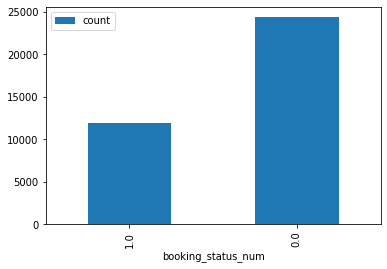

In [16]:
dfh.select('booking_status_num').groupBy('booking_status_num').count().toPandas().set_index('booking_status_num').plot.bar()

In [17]:
# 1 -> Cancela reserva
# 0 -> No cancela reserva

In [18]:
import seaborn as sns

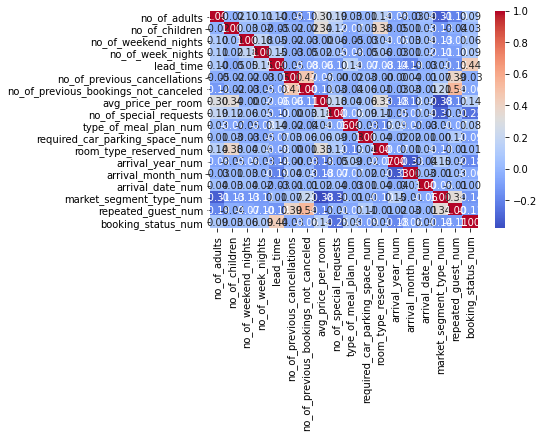

In [19]:
g = sns.heatmap(dfh.select('*').toPandas().corr(), 
                annot=True, fmt = ".2f", cmap = "coolwarm" )

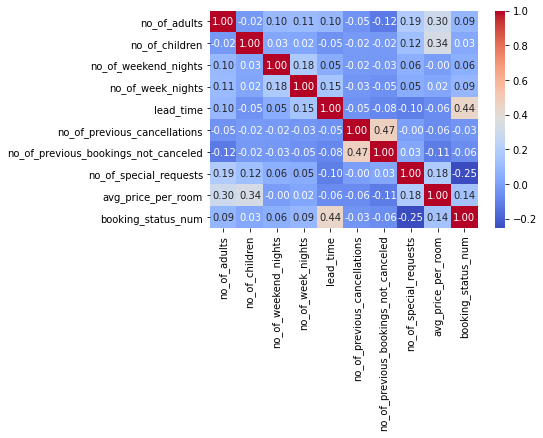

In [20]:
g = sns.heatmap(dfh.select(integer_cols+float_cols+['booking_status_num']).toPandas().corr(), 
                annot=True, fmt = ".2f", cmap = "coolwarm" )

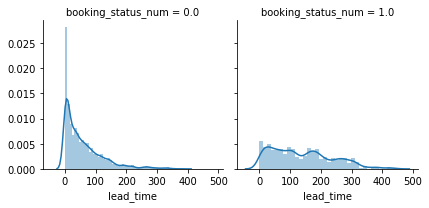

In [21]:
g = sns.FacetGrid(dfh.toPandas(), col='booking_status_num')
g = g.map(sns.distplot, 'lead_time')

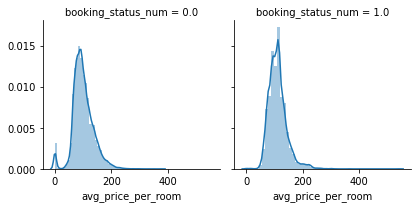

In [22]:
g = sns.FacetGrid(dfh.toPandas(), col='booking_status_num')
g = g.map(sns.distplot, 'avg_price_per_room')

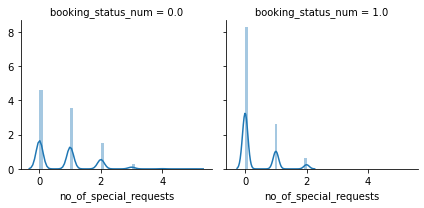

In [23]:
g = sns.FacetGrid(dfh.toPandas(), col='booking_status_num')
g = g.map(sns.distplot, 'no_of_special_requests')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


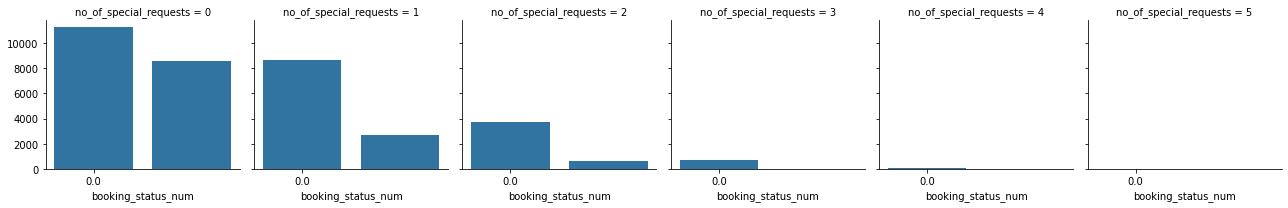

In [24]:
g = sns.FacetGrid(dfh.toPandas(), col='no_of_special_requests')
g = g.map(sns.countplot, 'booking_status_num')

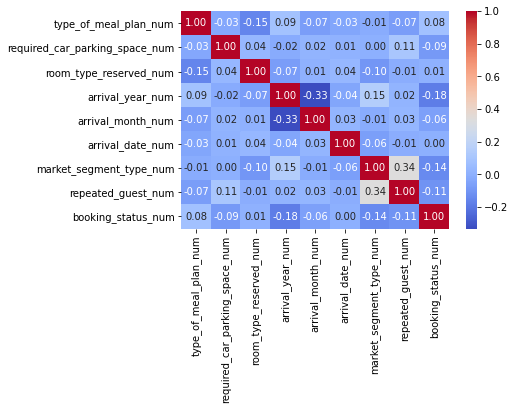

In [25]:
g = sns.heatmap(dfh.select(cat_cols_num).toPandas().corr(), 
                annot=True, fmt = ".2f", cmap = "coolwarm" )

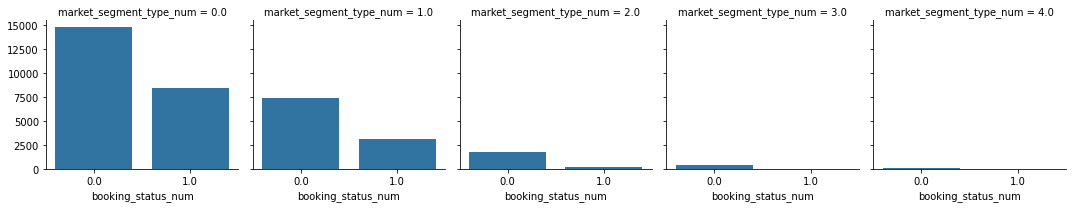

In [26]:
g = sns.FacetGrid(dfh.toPandas(), col='market_segment_type_num')
g = g.map(sns.countplot, 'booking_status_num')

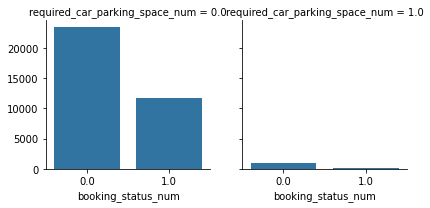

In [27]:
g = sns.FacetGrid(dfh.toPandas(), col='required_car_parking_space_num')
g = g.map(sns.countplot, 'booking_status_num')

In [28]:
import pyspark.sql.functions as f

In [29]:
rechazo_lead_time = dfh.filter((f.col('booking_status_num') == 1) & 
                         (f.col('lead_time').isNotNull())).select('lead_time').toPandas()
no_rechazo_lead_time = dfh.filter((f.col('booking_status_num') == 0) & (f.col('lead_time').isNotNull())).select('lead_time').toPandas()

In [30]:
rechazo_lead_time.squeeze()

0          1
1        211
2         48
3        346
4         30
        ... 
11880     49
11881    166
11882      0
11883    228
11884     63
Name: lead_time, Length: 11885, dtype: int32

In [31]:
type(rechazo_lead_time.squeeze())

pandas.core.series.Series

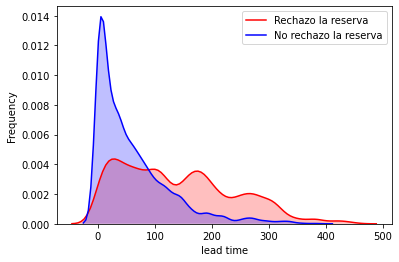

In [32]:
g = sns.kdeplot(rechazo_lead_time.squeeze(), color='Red', shade=True)
g = sns.kdeplot(no_rechazo_lead_time.squeeze(), color='Blue', shade=True)
g.set_xlabel('lead time')
g.set_ylabel('Frequency')
g.legend(['Rechazo la reserva', 'No rechazo la reserva'])

In [33]:
# Distribución de precio de boletos 
g = sns.distplot(df.select('fare').fillna(fare_mean).toPandas(), color='m')

NameError: name 'df' is not defined

## 3 - Valores Nulos y Constantes

In [34]:
# VALORES NULOS

In [35]:
dfh.select(f.sum(f.col('no_of_adults').isNull().cast('integer'))).show()

+----------------------------------------+
|sum(CAST((no_of_adults IS NULL) AS INT))|
+----------------------------------------+
|                                       0|
+----------------------------------------+



In [36]:
df_nulls = dfh.select([f.sum(f.col(c).isNull().cast('integer') / dfh.count()).alias(c) for c in dfh.columns])

In [37]:
df_nulls.show()

+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+---------------------+------------------------------+----------------------+----------------+-----------------+----------------+-----------------------+------------------+------------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|type_of_meal_plan_num|required_car_parking_space_num|room_type_reserved_num|arrival_year_num|arrival_month_

In [38]:
# VALORES CONSTANTES

In [39]:
num_cols = [c for c,dtype in dfh.dtypes if dtype.startswith(('int', 'double'))]
num_cols

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'type_of_meal_plan_num',
 'required_car_parking_space_num',
 'room_type_reserved_num',
 'arrival_year_num',
 'arrival_month_num',
 'arrival_date_num',
 'market_segment_type_num',
 'repeated_guest_num',
 'booking_status_num']

In [40]:
df_std = dfh.select([f.stddev(f.col(c)).alias(c) for c in num_cols])
df_std.show()

+------------------+------------------+--------------------+------------------+-----------------+----------------------------+------------------------------------+------------------+----------------------+---------------------+------------------------------+----------------------+------------------+-----------------+-----------------+-----------------------+-------------------+------------------+
|      no_of_adults|    no_of_children|no_of_weekend_nights| no_of_week_nights|        lead_time|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|type_of_meal_plan_num|required_car_parking_space_num|room_type_reserved_num|  arrival_year_num|arrival_month_num| arrival_date_num|market_segment_type_num| repeated_guest_num|booking_status_num|
+------------------+------------------+--------------------+------------------+-----------------+----------------------------+------------------------------------+------------------+------------------

In [41]:
df_std.toPandas()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_num,required_car_parking_space_num,room_type_reserved_num,arrival_year_num,arrival_month_num,arrival_date_num,market_segment_type_num,repeated_guest_num,booking_status_num
0,0.518715,0.402648,0.870644,1.410905,85.930817,0.368331,1.754171,35.089424,0.786236,0.634113,0.173281,0.7545,0.383836,3.290528,8.80374,0.681536,0.158053,0.469358


## 4 - Ingeniería de atributos

In [42]:
dfh.toPandas()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,booking_status,type_of_meal_plan_num,required_car_parking_space_num,room_type_reserved_num,arrival_year_num,arrival_month_num,arrival_date_num,market_segment_type_num,repeated_guest_num,booking_status_num
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,Not_Canceled,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,Not_Canceled,1.0,0.0,0.0,0.0,5.0,8.0,0.0,0.0,0.0
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,...,Canceled,0.0,0.0,0.0,0.0,10.0,21.0,0.0,0.0,1.0
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,...,Canceled,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0,1.0
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,...,Canceled,1.0,0.0,0.0,0.0,7.0,24.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,...,Not_Canceled,0.0,0.0,1.0,0.0,2.0,25.0,0.0,0.0,0.0
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,...,Canceled,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,...,Not_Canceled,0.0,0.0,0.0,0.0,6.0,19.0,0.0,0.0,0.0
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,...,Canceled,1.0,0.0,0.0,0.0,7.0,15.0,0.0,0.0,1.0


In [43]:
from pyspark.sql.functions import when, col, concat

In [44]:
dfh = dfh.withColumn('total_ocupantes', dfh['no_of_adults'] + dfh['no_of_children'])
dfh = dfh.withColumn('total_dias', dfh['no_of_weekend_nights'] + dfh['no_of_week_nights'])
dfh = dfh.withColumn('precio_x_ocupante', dfh['avg_price_per_room']/dfh['total_ocupantes'])
dfh = dfh.withColumn('precio_x_adulto', when(dfh['no_of_adults'] != 0,dfh['avg_price_per_room']/dfh['no_of_adults'])
                                       .otherwise(dfh['avg_price_per_room']))
dfh = dfh.withColumn('temporada_USA', when(dfh['arrival_month'].isin(["3","4","5"]), "primavera")
                                     .when(dfh['arrival_month'].isin(["6","7","8"]), "verano")
                                     .when(dfh['arrival_month'].isin(["9","10","11"]), "otoño")
                                     .otherwise("invierno"))
dfh = dfh.withColumn('type_of_meal_plan_SUM_room_type_reserved', concat(dfh['type_of_meal_plan'], dfh['room_type_reserved']))
dfh = dfh.withColumn('market_segment_type_SUM_room_type_reserved', concat(dfh['market_segment_type'], dfh['room_type_reserved']))
dfh = dfh.withColumn('market_segment_type_SUM_repeated_guest', concat(dfh['market_segment_type'], dfh['repeated_guest']))
dfh = dfh.withColumn('rango_de_montos', when(dfh['avg_price_per_room'] < 60, '0-60')
                                       .when((dfh['avg_price_per_room'] >= 60) & (dfh['avg_price_per_room'] < 80), '60-80')
                                       .when((dfh['avg_price_per_room'] >= 80) & (dfh['avg_price_per_room'] < 120), '80-120')
                                       .when((dfh['avg_price_per_room'] >= 120) & (dfh['avg_price_per_room'] < 150), '120-150')
                                       .otherwise(">150")
                    )
dfh = dfh.withColumn('rango_de_montos_SUM_temporada_USA', concat(dfh['rango_de_montos'], dfh['temporada_USA']))

In [45]:
dfh.toPandas()[['avg_price_per_room','no_of_adults','precio_x_adulto']]

,avg_price_per_room,no_of_adults,precio_x_adulto
0,65.00,2,32.500000
1,106.68,2,53.340000
2,60.00,1,60.000000
3,100.00,2,50.000000
4,94.50,2,47.250000
...,...,...,...
36270,167.80,3,55.933333
36271,90.95,2,45.475000
36272,98.39,2,49.195000
36273,94.50,2,47.250000


In [46]:
new_cat_cols = ['temporada_USA','type_of_meal_plan_SUM_room_type_reserved','market_segment_type_SUM_room_type_reserved','market_segment_type_SUM_repeated_guest','rango_de_montos','rango_de_montos_SUM_temporada_USA']

In [47]:
# Transformo en variables numéricas las nuevas variables con formato str

for cat in new_cat_cols:
    cat_suff = f'{cat}_num'
    if cat_suff not in dfh.columns:
        indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(dfh)
        dfh = indexer.transform(dfh)
dfh.show()

+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+---------------------+------------------------------+----------------------+----------------+-----------------+----------------+-----------------------+------------------+------------------+---------------+----------+------------------+------------------+-------------+----------------------------------------+------------------------------------------+--------------------------------------+---------------+---------------------------------+-----------------+--------------------------------------------+----------------------------------------------+------------------------------------------+-------------------+----------------------------------

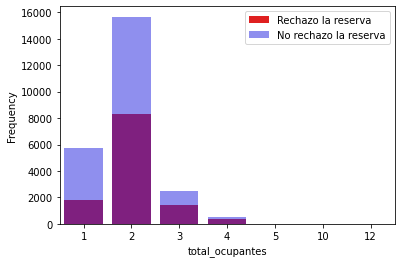

In [48]:
rechazo_total_ocupantes = dfh.filter((f.col('booking_status_num') == 1) & 
                         (f.col('total_ocupantes').isNotNull())).select('total_ocupantes').toPandas()
no_rechazo_total_ocupantes = dfh.filter((f.col('booking_status_num') == 0) & (f.col('total_ocupantes').isNotNull())).select('total_ocupantes').toPandas()

g = sns.countplot(rechazo_total_ocupantes.squeeze(), color='Red')
g = sns.countplot(no_rechazo_total_ocupantes.squeeze(), color='Blue', alpha=0.5)
g.set_xlabel('total_ocupantes')
g.set_ylabel('Frequency')
g.legend(['Rechazo la reserva', 'No rechazo la reserva'])

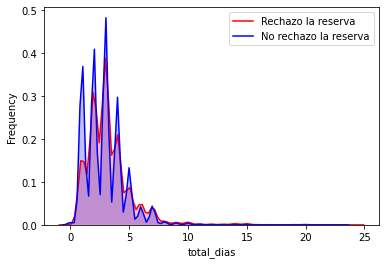

In [49]:
rechazo_total_dias = dfh.filter((f.col('booking_status_num') == 1) & 
                         (f.col('total_dias').isNotNull())).select('total_dias').toPandas()
no_rechazo_total_dias = dfh.filter((f.col('booking_status_num') == 0) & (f.col('total_dias').isNotNull())).select('total_dias').toPandas()

g = sns.kdeplot(rechazo_total_dias.squeeze(), color='Red', shade=True)
g = sns.kdeplot(no_rechazo_total_dias.squeeze(), color='Blue', shade=True)
g.set_xlabel('total_dias')
g.set_ylabel('Frequency')
g.legend(['Rechazo la reserva', 'No rechazo la reserva'])

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


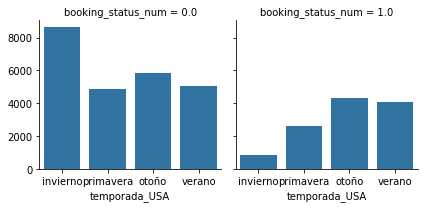

In [50]:
g = sns.FacetGrid(dfh.toPandas(), col='booking_status_num')
g = g.map(sns.countplot, 'temporada_USA')

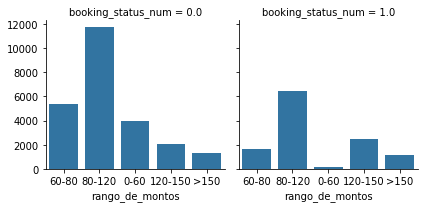

In [51]:
g = sns.FacetGrid(dfh.toPandas(), col='booking_status_num')
g = g.map(sns.countplot, 'rango_de_montos')

## 5 - Preparación de datos para realizar modelos ML

In [ ]:
# Eliminamos las columnas que representa el ID y las columnas del tipo string

In [52]:
dfh.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 44 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Booking_ID                                      36275 non-null  object 
 1   no_of_adults                                    36275 non-null  int32  
 2   no_of_children                                  36275 non-null  int32  
 3   no_of_weekend_nights                            36275 non-null  int32  
 4   no_of_week_nights                               36275 non-null  int32  
 5   type_of_meal_plan                               36275 non-null  object 
 6   required_car_parking_space                      36275 non-null  object 
 7   room_type_reserved                              36275 non-null  object 
 8   lead_time                                       36275 non-null  int32  
 9   arrival_year                           

In [53]:
columns_to_delete = new_cat_cols + cat_cols + ['Booking_ID']
columns_to_delete

['temporada_USA',
 'type_of_meal_plan_SUM_room_type_reserved',
 'market_segment_type_SUM_room_type_reserved',
 'market_segment_type_SUM_repeated_guest',
 'rango_de_montos',
 'rango_de_montos_SUM_temporada_USA',
 'type_of_meal_plan',
 'required_car_parking_space',
 'room_type_reserved',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'booking_status',
 'Booking_ID']

In [54]:
dfh_model = dfh.drop(*columns_to_delete)
dfh_model.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   no_of_adults                                    36275 non-null  int32  
 1   no_of_children                                  36275 non-null  int32  
 2   no_of_weekend_nights                            36275 non-null  int32  
 3   no_of_week_nights                               36275 non-null  int32  
 4   lead_time                                       36275 non-null  int32  
 5   no_of_previous_cancellations                    36275 non-null  int32  
 6   no_of_previous_bookings_not_canceled            36275 non-null  int32  
 7   avg_price_per_room                              36275 non-null  float64
 8   no_of_special_requests                          36275 non-null  int32  
 9   type_of_meal_plan_num                  

In [55]:
# BALANCEO DE DATOS

In [56]:
dfh_model.toPandas()['booking_status_num'].value_counts(normalize=True)*100

0.0    67.236389
1.0    32.763611
Name: booking_status_num, dtype: float64

In [57]:
#dfh_model = dfh_model.withColumn("class", when(col("booking_status_num") == 0, "clase 0").otherwise("clase 1"))

In [58]:
# CHECKEO DE NULOS

In [59]:
df_nulls_2 = dfh_model.select([f.sum(f.col(c).isNull().cast('integer') / dfh_model.count()).alias(c) for c in dfh_model.columns])
df_nulls_2.show()

+------------+--------------+--------------------+-----------------+---------+----------------------------+------------------------------------+------------------+----------------------+---------------------+------------------------------+----------------------+----------------+-----------------+----------------+-----------------------+------------------+------------------+---------------+----------+-----------------+---------------+-----------------+--------------------------------------------+----------------------------------------------+------------------------------------------+-------------------+-------------------------------------+
|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|lead_time|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|type_of_meal_plan_num|required_car_parking_space_num|room_type_reserved_num|arrival_year_num|arrival_month_num|arrival_date_num|market_segment_type_num|repeated_gues

In [60]:
null_cols = [c for c in df_nulls_2.columns if df_nulls_2.select(c).first()[0] > 0]
null_cols

[]

In [ ]:
# VECTOR ASSEMBLER

In [61]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[c for c in dfh_model.columns if c != 'booking_status_num'], outputCol="features")
dfh_model_assembler = assembler.transform(dfh_model)
dfh_model_assembler.select('features').show()

+--------------------+
|            features|
+--------------------+
|(27,[0,2,3,4,7,12...|
|(27,[0,2,3,4,7,8,...|
|(27,[0,2,3,4,7,13...|
|(27,[0,3,4,7,13,1...|
|(27,[0,2,3,4,7,9,...|
|(27,[0,3,4,7,8,9,...|
|(27,[0,2,3,4,7,8,...|
|[2.0,0.0,1.0,3.0,...|
|(27,[0,3,4,7,8,13...|
|(27,[0,3,4,7,8,11...|
|(27,[0,2,7,9,13,1...|
|[1.0,0.0,2.0,1.0,...|
|(27,[0,2,3,4,7,9,...|
|(27,[0,2,4,7,8,13...|
|(27,[0,3,4,7,8,12...|
|(27,[0,3,4,7,8,9,...|
|(27,[0,2,7,12,14,...|
|[2.0,0.0,1.0,3.0,...|
|(27,[0,2,3,4,7,12...|
|(27,[0,2,4,7,12,1...|
+--------------------+
only showing top 20 rows



In [ ]:
# TRAIN TEST 

In [62]:
# Train/test split
train_df, test_df = dfh_model_assembler.randomSplit([0.7,0.3],seed=42)

In [63]:
train_df.toPandas()['booking_status_num'].value_counts(normalize=True)*100

0.0    66.944967
1.0    33.055033
Name: booking_status_num, dtype: float64

In [64]:
test_df.toPandas()['booking_status_num'].value_counts(normalize=True)*100

0.0    67.927158
1.0    32.072842
Name: booking_status_num, dtype: float64

## 6 - Árbol de decisión

In [91]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='booking_status_num', featuresCol='features', seed=42)
dtm = dt.fit(train_df)

In [92]:
pred_df = dtm.transform(test_df)
pred_df.show()

+------------+--------------+--------------------+-----------------+---------+----------------------------+------------------------------------+------------------+----------------------+---------------------+------------------------------+----------------------+----------------+-----------------+----------------+-----------------------+------------------+------------------+---------------+----------+-----------------+---------------+-----------------+--------------------------------------------+----------------------------------------------+------------------------------------------+-------------------+-------------------------------------+--------------------+---------------+--------------------+----------+
|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|lead_time|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|type_of_meal_plan_num|required_car_parking_space_num|room_type_reserved_num|arrival_year_num|arr

In [93]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator_auc = BinaryClassificationEvaluator(labelCol='booking_status_num')

In [81]:
#evaluator_precision = BinaryClassificationEvaluator(labelCol='booking_status_num', metricName='weightedPrecision')
#evaluator_recall = BinaryClassificationEvaluator(labelCol='booking_status_num', metricName='weightedRecall')
#evaluator_f1 = BinaryClassificationEvaluator(labelCol='booking_status_num', metricName="f1")

In [94]:
evaluator_auc.evaluate(pred_df)

0.7206791524953354

In [95]:
dtm.featureImportances

SparseVector(27, {2: 0.0117, 4: 0.4852, 7: 0.0824, 8: 0.1416, 13: 0.0328, 14: 0.004, 15: 0.0115, 17: 0.0423, 24: 0.1759, 26: 0.0126})

In [85]:
import pandas as pd

In [96]:
from itertools import chain
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, dtm.featureImportances[idx]) for idx, name in attrs if dtm.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
feat_import.head(15)

,feature,importance
1,lead_time,0.485230
8,market_segment_type_SUM_repeated_guest_num,0.175949
3,no_of_special_requests,0.141646
2,avg_price_per_room,0.082420
7,total_ocupantes,0.042312
4,arrival_month_num,0.032786
9,rango_de_montos_SUM_temporada_USA_num,0.012594
0,no_of_weekend_nights,0.011653
6,market_segment_type_num,0.011451
5,arrival_date_num,0.003960


## 7 - Random Forest

In [97]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='booking_status_num', featuresCol='features', seed=42)
rfm = rf.fit(train_df)
pred_df = rfm.transform(test_df)
pred_df.show()

+------------+--------------+--------------------+-----------------+---------+----------------------------+------------------------------------+------------------+----------------------+---------------------+------------------------------+----------------------+----------------+-----------------+----------------+-----------------------+------------------+------------------+---------------+----------+-----------------+---------------+-----------------+--------------------------------------------+----------------------------------------------+------------------------------------------+-------------------+-------------------------------------+--------------------+--------------------+--------------------+----------+
|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|lead_time|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|type_of_meal_plan_num|required_car_parking_space_num|room_type_reserved_num|arrival_year_nu

In [98]:
evaluator_auc.evaluate(pred_df)

0.8795564803143496

In [99]:
from itertools import chain
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, rfm.featureImportances[idx]) for idx, name in attrs if rfm.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
feat_import.head(15)

,feature,importance
4,lead_time,0.397153
6,no_of_special_requests,0.163323
5,avg_price_per_room,0.073923
13,market_segment_type_num,0.054946
23,rango_de_montos_SUM_temporada_USA_num,0.042304
21,market_segment_type_SUM_repeated_guest_num,0.041877
10,arrival_year_num,0.041341
20,market_segment_type_SUM_room_type_reserved_num,0.035133
11,arrival_month_num,0.027638
12,arrival_date_num,0.022875
